## Run MD with vanilla/og system and then check that difference in energies between vanilla vs rest system are close to 0

In [21]:
from tqdm import tqdm_notebook
import openmmtools
import matplotlib.pyplot as plt
import pickle

from simtk.openmm import unit
import openmmtools
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache

from perses.annihilation.rest import RESTTopologyFactoryV3
from perses.annihilation.lambda_protocol import RESTStateV3
from perses.dispersed import feptasks

In [3]:
with open("T42A_complex_0.pickle", "rb") as f:
    htf = pickle.load(f)

INFO:rdkit:Enabling RDKit 2021.03.5 jupyter extensions


In [7]:
# Create REST-ified hybrid system
rest_atoms = list(htf._atom_classes['unique_old_atoms']) + list(htf._atom_classes['unique_new_atoms'])
factory = RESTTopologyFactoryV3(htf.hybrid_system, htf.hybrid_topology, rest_region=rest_atoms, use_dispersion_correction=True)
REST_system = factory.REST_system

INFO:REST:*** Generating RESTTopologyFactoryV3 ***
INFO:REST:No unknown forces.
INFO:REST:alpha_ewald is 2.7569734238004693
INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.7997, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.7997, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.7997), unit=nanometer)]


In [32]:
# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 300.0 * unit.kelvin  # Minimum temperature.

# Create thermodynamic state for rest
lambda_zero_alchemical_state = RESTStateV3.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

# Create thermodynamic state for og system
thermostate = ThermodynamicState(htf.hybrid_system, temperature=T_min)


In [33]:
# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())

In [34]:
context_cache = cache.global_context_cache

In [35]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)

In [36]:
feptasks.minimize(thermostate, sampler_state, max_iterations=0)

In [37]:
context, integrator = context_cache.get_context(thermostate, integrator)
sampler_state.apply_to_context(context)


In [ ]:
hybrid = list()
energies = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    hybrid.append(pos)

/var/folders/47/gc5xdnpd54v4tkhd4lvyjxzmhxxhqn/T/ipykernel_77464/3301661475.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [93]:
energies_og = list()
energies_rest = list()
for pos in tqdm_notebook(hybrid):
    integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)
    context = thermostate.create_context(integrator)
    context.setPositions(pos)
    sampler_state = SamplerState.from_context(context)
    energy = thermostate.reduced_potential(sampler_state)
    energies_og.append(energy)
    
    thermostate = compound_thermodynamic_state
    integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)
    context = thermostate.create_context(integrator)
    context.setPositions(pos)
    sampler_state = SamplerState.from_context(context)
    energy = thermostate.reduced_potential(sampler_state)
    energies_rest.append(energy)

<ipython-input-93-807df311909c>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pos in tqdm_notebook(hybrid):


  0%|          | 0/500 [00:00<?, ?it/s]

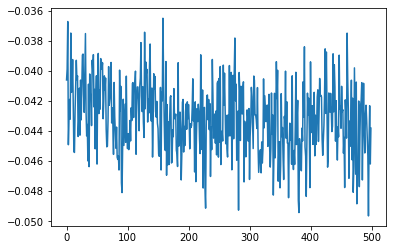

In [94]:
plt.plot(np.array(energies_og) - np.array(energies_rest))

In [95]:
np.std(np.array(energies_300) - np.array(energies_301))

0.002372571416010197